# Vainilla_GAN
- 원본코드 출처 : https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py#L46

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
from matplotlib import pyplot as plt
import imageio

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(28)

In [3]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100
batch_size = 100
sample_dir = 'samples'
check_dir = 'checkpoints'

In [4]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

In [5]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

In [6]:
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

In [7]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [8]:
print("batch cnt:",len(data_loader))
print("data cnt:",len(data_loader)*batch_size)

batch cnt: 600
data cnt: 60000


In [9]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [10]:
# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [11]:
# Device setting
D = D.to(device)
G = G.to(device)

In [12]:
print(D)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


In [13]:
print(G)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)


In [14]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [15]:
# clamp(최소값, 최대값)
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [16]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [17]:
g_losses = []
d_losses = []
images = []

# Start training
total_step = len(data_loader)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device) # 1
        fake_labels = torch.zeros(batch_size, 1).to(device) # 0
    
        # Train the discriminator
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train the generator
        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()


        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
        
        
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
    

Epoch [0/100], Step [200/600], d_loss: 0.0595, g_loss: 4.4474, D(x): 0.99, D(G(z)): 0.05
Epoch [0/100], Step [400/600], d_loss: 0.1665, g_loss: 5.5258, D(x): 0.92, D(G(z)): 0.05
Epoch [0/100], Step [600/600], d_loss: 0.0473, g_loss: 5.0348, D(x): 0.98, D(G(z)): 0.02
Epoch [1/100], Step [200/600], d_loss: 0.0490, g_loss: 5.1447, D(x): 0.98, D(G(z)): 0.03
Epoch [1/100], Step [400/600], d_loss: 0.1573, g_loss: 5.3277, D(x): 0.97, D(G(z)): 0.11
Epoch [1/100], Step [600/600], d_loss: 0.3645, g_loss: 4.3346, D(x): 0.93, D(G(z)): 0.20
Epoch [2/100], Step [200/600], d_loss: 0.1593, g_loss: 4.0301, D(x): 0.96, D(G(z)): 0.08
Epoch [2/100], Step [400/600], d_loss: 0.7078, g_loss: 3.4185, D(x): 0.86, D(G(z)): 0.23
Epoch [2/100], Step [600/600], d_loss: 0.2883, g_loss: 4.0953, D(x): 0.91, D(G(z)): 0.10
Epoch [3/100], Step [200/600], d_loss: 0.8961, g_loss: 3.2988, D(x): 0.80, D(G(z)): 0.32
Epoch [3/100], Step [400/600], d_loss: 0.1798, g_loss: 4.1427, D(x): 0.93, D(G(z)): 0.08
Epoch [3/100], Step [

Epoch [30/100], Step [600/600], d_loss: 0.4580, g_loss: 3.8354, D(x): 0.78, D(G(z)): 0.06
Epoch [31/100], Step [200/600], d_loss: 0.5273, g_loss: 3.0559, D(x): 0.85, D(G(z)): 0.15
Epoch [31/100], Step [400/600], d_loss: 0.4656, g_loss: 2.9014, D(x): 0.84, D(G(z)): 0.10
Epoch [31/100], Step [600/600], d_loss: 0.3154, g_loss: 2.8462, D(x): 0.90, D(G(z)): 0.13
Epoch [32/100], Step [200/600], d_loss: 0.5062, g_loss: 1.9580, D(x): 0.93, D(G(z)): 0.26
Epoch [32/100], Step [400/600], d_loss: 0.4186, g_loss: 3.4455, D(x): 0.91, D(G(z)): 0.17
Epoch [32/100], Step [600/600], d_loss: 0.3863, g_loss: 3.6899, D(x): 0.90, D(G(z)): 0.17
Epoch [33/100], Step [200/600], d_loss: 0.6082, g_loss: 2.7851, D(x): 0.78, D(G(z)): 0.10
Epoch [33/100], Step [400/600], d_loss: 0.6619, g_loss: 2.1742, D(x): 0.78, D(G(z)): 0.13
Epoch [33/100], Step [600/600], d_loss: 0.5566, g_loss: 2.8425, D(x): 0.81, D(G(z)): 0.15
Epoch [34/100], Step [200/600], d_loss: 0.4917, g_loss: 3.0983, D(x): 0.84, D(G(z)): 0.16
Epoch [34/

Epoch [61/100], Step [400/600], d_loss: 0.8044, g_loss: 2.1258, D(x): 0.70, D(G(z)): 0.18
Epoch [61/100], Step [600/600], d_loss: 0.5123, g_loss: 2.2824, D(x): 0.83, D(G(z)): 0.18
Epoch [62/100], Step [200/600], d_loss: 0.6388, g_loss: 2.4393, D(x): 0.84, D(G(z)): 0.25
Epoch [62/100], Step [400/600], d_loss: 0.6933, g_loss: 2.4411, D(x): 0.80, D(G(z)): 0.20
Epoch [62/100], Step [600/600], d_loss: 0.5457, g_loss: 2.5488, D(x): 0.84, D(G(z)): 0.19
Epoch [63/100], Step [200/600], d_loss: 0.4908, g_loss: 2.2608, D(x): 0.88, D(G(z)): 0.25
Epoch [63/100], Step [400/600], d_loss: 0.6229, g_loss: 2.4718, D(x): 0.82, D(G(z)): 0.21
Epoch [63/100], Step [600/600], d_loss: 0.5951, g_loss: 2.0629, D(x): 0.78, D(G(z)): 0.16
Epoch [64/100], Step [200/600], d_loss: 0.5546, g_loss: 2.2897, D(x): 0.80, D(G(z)): 0.20
Epoch [64/100], Step [400/600], d_loss: 0.6310, g_loss: 2.9586, D(x): 0.84, D(G(z)): 0.25
Epoch [64/100], Step [600/600], d_loss: 0.9435, g_loss: 1.5268, D(x): 0.79, D(G(z)): 0.37
Epoch [65/

Epoch [92/100], Step [200/600], d_loss: 0.8523, g_loss: 2.3863, D(x): 0.65, D(G(z)): 0.17
Epoch [92/100], Step [400/600], d_loss: 0.8084, g_loss: 2.0057, D(x): 0.77, D(G(z)): 0.30
Epoch [92/100], Step [600/600], d_loss: 0.8074, g_loss: 1.5858, D(x): 0.81, D(G(z)): 0.34
Epoch [93/100], Step [200/600], d_loss: 0.9359, g_loss: 1.9939, D(x): 0.74, D(G(z)): 0.35
Epoch [93/100], Step [400/600], d_loss: 0.7392, g_loss: 1.6624, D(x): 0.74, D(G(z)): 0.26
Epoch [93/100], Step [600/600], d_loss: 0.8842, g_loss: 1.7367, D(x): 0.73, D(G(z)): 0.30
Epoch [94/100], Step [200/600], d_loss: 0.8542, g_loss: 1.6541, D(x): 0.78, D(G(z)): 0.34
Epoch [94/100], Step [400/600], d_loss: 0.8115, g_loss: 2.0696, D(x): 0.72, D(G(z)): 0.23
Epoch [94/100], Step [600/600], d_loss: 0.8950, g_loss: 1.4651, D(x): 0.74, D(G(z)): 0.32
Epoch [95/100], Step [200/600], d_loss: 0.6310, g_loss: 1.8321, D(x): 0.76, D(G(z)): 0.17
Epoch [95/100], Step [400/600], d_loss: 0.6999, g_loss: 1.9828, D(x): 0.73, D(G(z)): 0.21
Epoch [95/

In [18]:
# Save the model checkpoints 
torch.save(G.state_dict(), './checkpoints/G.ckpt')
torch.save(D.state_dict(), './checkpoints/D.ckpt')

Text(0.5, 1.0, 'Loss')

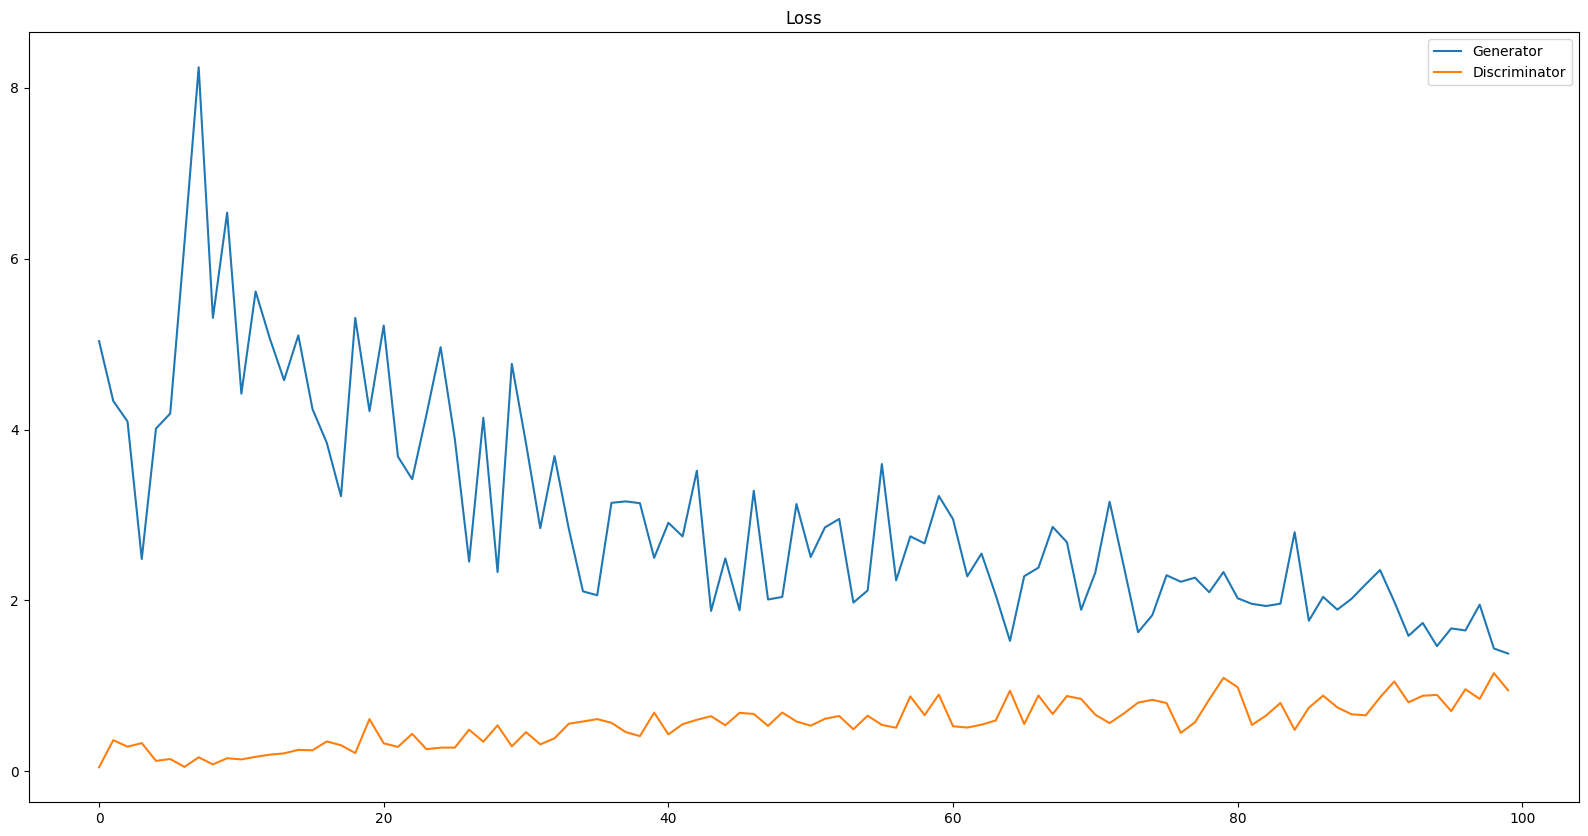

In [19]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
# plt.savefig('gan_loss.png')